# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
conf.set("spark.executor.memory", "4g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -copyFromLocal data

copyFromLocal: `data/.DS_Store': File exists
copyFromLocal: `data/ml-25m/README.txt': File exists
copyFromLocal: `data/ml-25m/genome-scores.csv': File exists
copyFromLocal: `data/ml-25m/genome-tags.csv': File exists
copyFromLocal: `data/ml-25m/links.csv': File exists
copyFromLocal: `data/ml-25m/ml-25m-README.htm': File exists
copyFromLocal: `data/ml-25m/movies.csv': File exists
copyFromLocal: `data/ml-25m/ratings.csv': File exists
copyFromLocal: `data/ml-25m/tags.csv': File exists
copyFromLocal: `data/ml-25m/tmdb.json': File exists


In [5]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2020-03-25 14:54 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2020-03-25 14:54 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2020-03-25 14:55 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2020-03-25 14:55 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2020-03-25 14:55 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2020-03-25 14:55 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2020-03-25 14:55 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2020-03-25 14:55 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2020-03-25 14:55 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [6]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [7]:
ratings = sc.textFile(RATINGS_PATH)

In [14]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [15]:
ratings.getNumPartitions()

5

In [8]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [17]:
ratings.count()

25000095

Количество пользователей

In [17]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 60 ms, sys: 20 ms, total: 80 ms
Wall time: 3min 20s


162541

Сохраним датасет в память

In [6]:
ratings = ratings.persist()

In [8]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 20 ms, sys: 50 ms, total: 70 ms
Wall time: 1min 28s


162541

Количество фильмов

In [9]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [9]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [10]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [20]:
movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [24]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [25]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2020-03-25 12:35 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58903 2020-03-25 12:35 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112361 2020-03-25 12:35 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131524 2020-03-25 12:35 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114377 2020-03-25 12:35 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133576 2020-03-25 12:35 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117783 2020-03-25 12:35 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143242 2020-03-25 12:35 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     131984 2020-03-25 12:35 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167729 2020-03-25 12:35 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [11]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [28]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [31]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

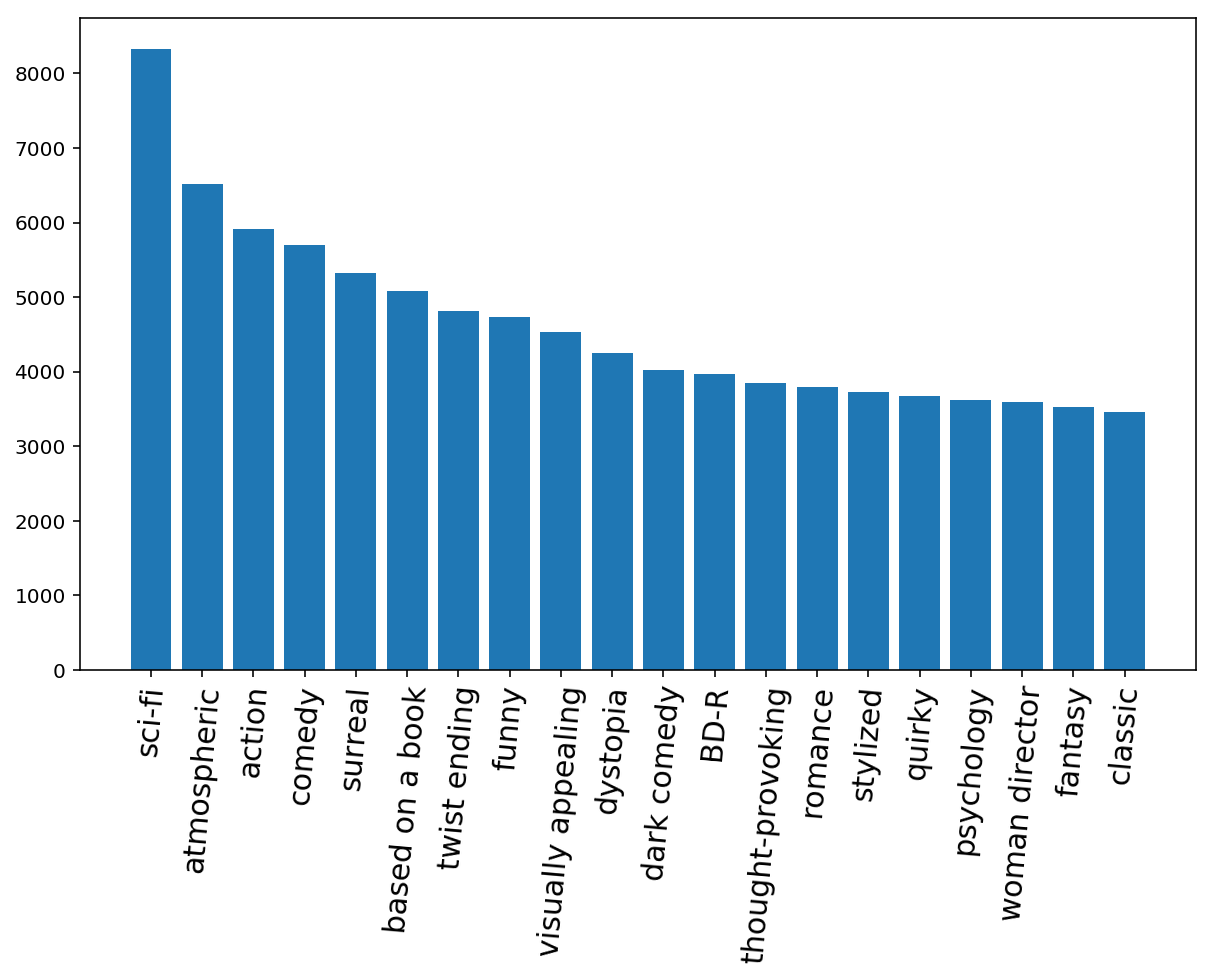

In [37]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [22]:
movie_max_rated = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)

movie_max_rated\
    .join(movies)\
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .map(lambda key_value: (key_value[1][1][1],key_value[1][0]))\
    .take(10)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [23]:
movie_5 = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .filter(lambda r: r[1][0]==5) \
    .reduceByKey(lambda a, b: (5,a[1]+b[1]))\
    .map(lambda r: (r[0],r[1][1]))

movie_5 \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .map(lambda key_value: (key_value[1][1][1],key_value[1][0])) \
    .take(10)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [26]:
movie_avg_rating.take(5)

[(32770, 3.5727272727272728),
 (5, 3.0584343520573674),
 (196615, 3.5),
 (131080, 3.0),
 (10, 3.42145763311516)]

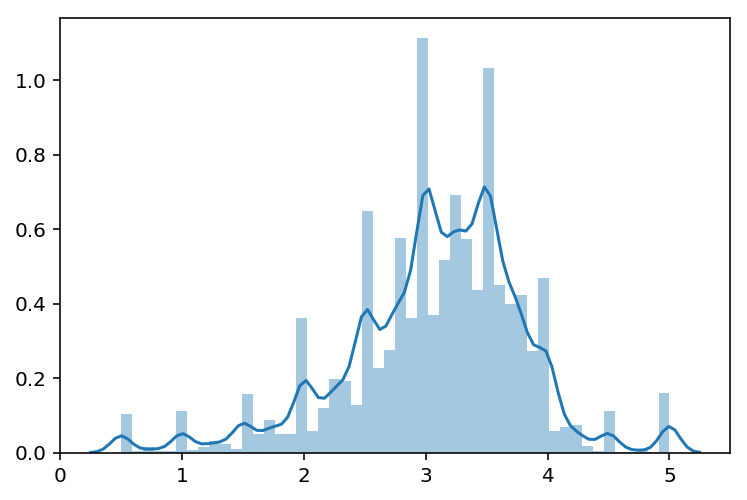

In [47]:
import seaborn as sns
sns.distplot(movie_avg_rating \
    .map(lambda r: r[1])\
    .collect())
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

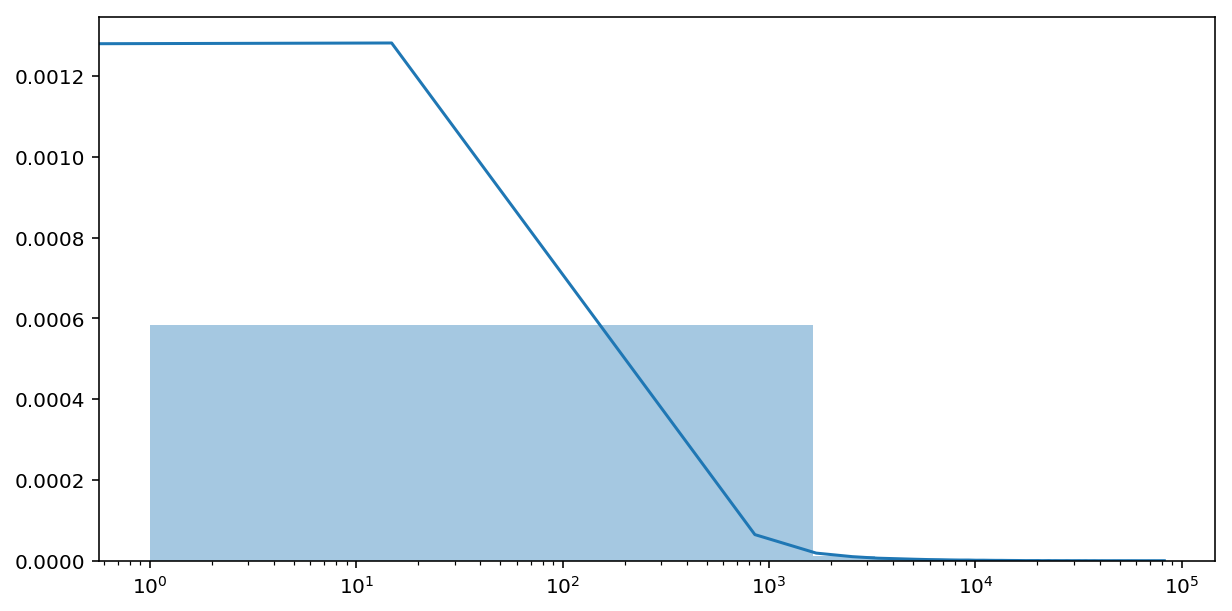

In [94]:
plt.figure(figsize=(10,5))
plt.xscale('log')
sns.distplot(movie_max_rated\
        .map(lambda r: r[1])
        .collect())
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [139]:
genres = sc.textFile(MOVIES_PATH)
genres = genres \
    .map(lambda x: x.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0])) \
    .flatMap(lambda arr: arr[1][-1].split('|')) \
    .map(lambda x: (x,1)) \
    .reduceByKey(lambda a,b: a+b) \
    .sortBy(lambda arr: arr[1], ascending=False)

In [140]:
genres.take(6)

[('Drama', 25606),
 ('Comedy', 16870),
 ('Thriller', 8654),
 ('Romance', 7719),
 ('Action', 7348),
 ('Horror', 5989)]

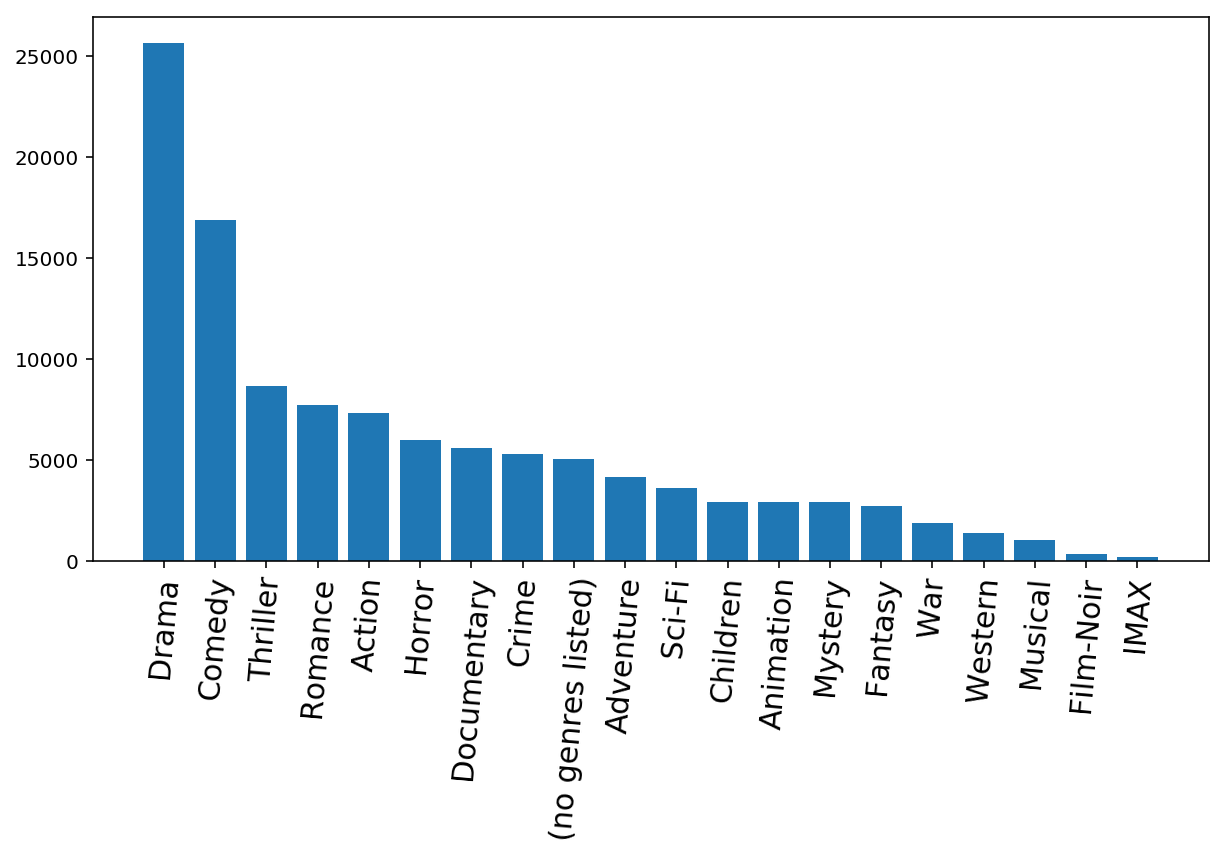

In [141]:
genres_top20 = genres.take(20)
plt.figure(figsize=(10,5))
plt.bar(*zip(*genres_top20))
plt.xticks(rotation=85, fontsize=15)
plt.show()

In [149]:
genres_names = list(map(lambda x:x[0],genres.collect()))

In [151]:
genres_names

['Drama',
 'Comedy',
 'Thriller',
 'Romance',
 'Action',
 'Horror',
 'Documentary',
 'Crime',
 '(no genres listed)',
 'Adventure',
 'Sci-Fi',
 'Children',
 'Animation',
 'Mystery',
 'Fantasy',
 'War',
 'Western',
 'Musical',
 'Film-Noir',
 'IMAX']

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [12]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
links = sc.textFile(LINKS_PATH)
links.take(5)

['movieId,imdbId,tmdbId',
 '1,0114709,862',
 '2,0113497,8844',
 '3,0113228,15602',
 '4,0114885,31357']

In [13]:
links = links \
        .map(lambda x: x.split(',')) \
        .filter(lambda arr: arr[0].isdigit() 
                and arr[2].isdigit()) \
        .map(lambda arr: (arr[0], int(arr[2]))) \
        .keyBy(lambda arr: int(arr[0])) \
#         .collect()

In [14]:
links.take(5)

[(1, ('1', 862)),
 (2, ('2', 8844)),
 (3, ('3', 15602)),
 (4, ('4', 31357)),
 (5, ('5', 11862))]

In [15]:
tmdb_id_by_links = links \
    .map(lambda x: x[1][1]) \
    .collect()

In [16]:
import json

In [17]:
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')
tmdb = sc.textFile(TMDB_PATH)
# tmdb.take(5)

In [18]:
tmdb = tmdb \
    .map(lambda x: json.loads(x)) \
    .filter(lambda js: js.get('id', None) in tmdb_id_by_links) \
    .keyBy(lambda js: js.get('id', None))

In [46]:
cast_ids = tmdb \
    .map(lambda kv: (kv[0], kv[1].get('casts', None).get('cast', None))) \
    .map(lambda kv: (kv[0], list(map(lambda x: (x['id'], x['name']), kv[1])))) \
    .flatMapValues(lambda x: x) \
    .map(lambda x: (x[1][0],(x[0],x[1][1])))


In [47]:
cast_ids.take(5)

[(31, (862, 'Tom Hanks')),
 (12898, (862, 'Tim Allen')),
 (7167, (862, 'Don Rickles')),
 (12899, (862, 'Jim Varney')),
 (12900, (862, 'Wallace Shawn'))]

In [51]:
tmdb_films_id_with_Tom = cast_ids \
    .filter(lambda x: x[0]==31) \
    .map(lambda x: x[1][0]) \
    .collect()

In [52]:
movie_id_with_Tom = links \
            .filter(lambda x: x[1][1] in tmdb_films_id_with_Tom) \
            .map(lambda x: x[0]) \
            .collect()

In [53]:
movies.take(5)

[(1, ['1', 'Toy Story (1995)']),
 (2, ['2', 'Jumanji (1995)']),
 (3, ['3', 'Grumpier Old Men (1995)']),
 (4, ['4', 'Waiting to Exhale (1995)']),
 (5, ['5', 'Father of the Bride Part II (1995)'])]

In [54]:
movies \
.filter(lambda x: x[0] in movie_id_with_Tom) \
.map(lambda x: x[1][1]) \
.collect()

['Toy Story (1995)',
 'Apollo 13 (1995)',
 'Forrest Gump (1994)',
 'Philadelphia (1993)',
 'Sleepless in Seattle (1993)',
 '"Celluloid Closet',
 'That Thing You Do! (1996)',
 'Saving Private Ryan (1998)',
 '"\'burbs',
 'Splash (1984)',
 '"Money Pit',
 'Nothing in Common (1986)',
 "You've Got Mail (1998)",
 'Big (1988)',
 'Return with Honor (1998)',
 'Toy Story 2 (1999)',
 'Bonfire of the Vanities (1990)',
 '"Green Mile',
 '"League of Their Own',
 'Volunteers (1985)',
 'Bachelor Party (1984)',
 'Punchline (1988)',
 'Cast Away (2000)',
 'Turner & Hooch (1989)',
 "He Knows You're Alone (a.k.a. Blood Wedding) (1980)",
 'Joe Versus the Volcano (1990)',
 'Road to Perdition (2002)',
 'Catch Me If You Can (2002)',
 'Radio Flyer (1992)',
 'Dragnet (1987)',
 '"Ladykillers',
 '"Terminal',
 '"Man with One Red Shoe',
 '"Polar Express',
 '"Da Vinci Code',
 'Cars (2006)',
 '"Simpsons Movie',
 "Charlie Wilson's War (2007)",
 '"Great Buck Howard',
 'Angels & Demons (2009)',
 'Shooting War (2000)',
 'To

In [55]:
cast_ids.take(5)

[(31, (862, 'Tom Hanks')),
 (12898, (862, 'Tim Allen')),
 (7167, (862, 'Don Rickles')),
 (12899, (862, 'Jim Varney')),
 (12900, (862, 'Wallace Shawn'))]

In [59]:
cast_ids \
.map(lambda x: (x[0],(x[1][1],1))) \
.reduceByKey(lambda a,b: (a[0],a[1]+b[1])) \
.sortBy(lambda x: x[1][1], ascending=False) \
.map(lambda x: x[1]) \
.take(10)
     

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 130)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [60]:
plt.stackplot?

In [68]:
import numpy as np

In [73]:
x = range(10)
y = [list(range(-4,7))]
for i in range(9):
    y.append([0.95*j for j in y[-1]])
x = np.array(x)
y = np.array(y)

In [74]:
y.shape

(10, 11)

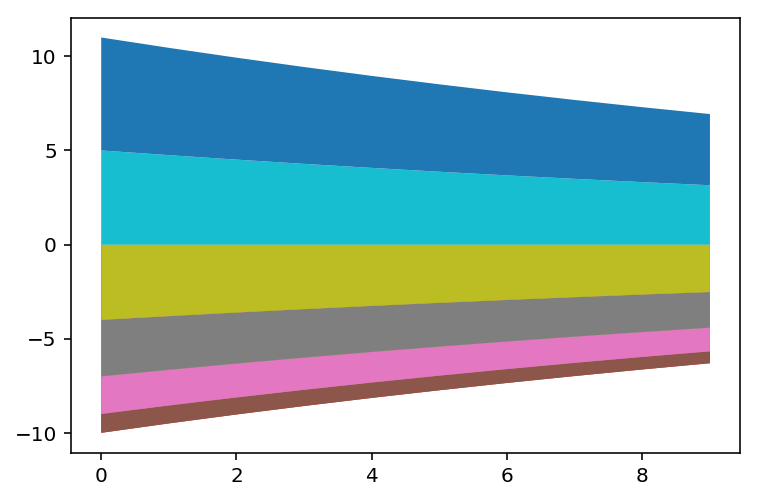

In [75]:
plt.stackplot(x,y.T)

In [154]:
genres = sc.textFile(MOVIES_PATH)
genres = genres \
    .map(lambda x: x.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0])) \
    .map(lambda arr: (arr[0],arr[1][-1].split('|'))) \
    .flatMapValues(lambda arr: arr)
#     .map(lambda x: (x,1)) \
#     .reduceByKey(lambda a,b: a+b) \
#     .sortBy(lambda arr: arr[1], ascending=False)

In [155]:
genres.take(10)

[(1, 'Adventure'),
 (1, 'Animation'),
 (1, 'Children'),
 (1, 'Comedy'),
 (1, 'Fantasy'),
 (2, 'Adventure'),
 (2, 'Children'),
 (2, 'Fantasy'),
 (3, 'Comedy'),
 (3, 'Romance')]

In [156]:
year_by_tmdb_id = tmdb \
.map(lambda kv: (kv[0], kv[1].get('release_date', None))) \
.map(lambda x: (x[0], x[1].split('-')[0])) \
.filter(lambda x: x[1].isdigit())

In [157]:
year_by_id = links \
.map(lambda x:(x[1][1],x[0])) \
.join(year_by_tmdb_id) \
.map(lambda x: x[1]) \
.map(lambda x: (x[0],int(x[1])))

In [170]:
id_genre_year_count = genres \
.join(year_by_id) \
.filter(lambda x: x[1][0] in genres_names) \
.map(lambda x: ((x[1][1],x[1][0]), 1)) \
.reduceByKey(lambda a,b: a+b) \
.sortBy(lambda x: x[0][0])

In [171]:
id_genre_year_count.take(5)

[((1874, 'Documentary'), 1),
 ((1878, '(no genres listed)'), 1),
 ((1881, 'Documentary'), 1),
 ((1883, '(no genres listed)'), 1),
 ((1887, '(no genres listed)'), 1)]

In [176]:
min_year = id_genre_year_count.min()[0][0]
max_year = id_genre_year_count.max()[0][0]
min_year, max_year

(1874, 2021)

In [207]:
years = range(min_year, max_year+1)
d = dict()
for year in years:
    d[year] = dict()
    for genre in genres_names:
        d[year][genre] = 0
for kv in id_genre_year_count.collect():
    d[kv[0][0]][kv[0][1]]+=kv[1]

In [208]:
deleted = []
for year in years:
    sum_ = 0
    for genre in genres_names:
        sum_+=d[year][genre]
    if sum_==0:
        del d[year]
        deleted.append(year)
    else:
        for genre in genres_names:
            d[year][genre]/=sum_

In [209]:
deleted

[1875, 1876, 1877, 1879, 1880, 1882, 1884, 1885, 1886, 1889, 1893]

In [210]:
d[1995]

{'(no genres listed)': 0.05259087393658159,
 'Action': 0.0920340293890178,
 'Adventure': 0.03557617942768755,
 'Animation': 0.020108275328692964,
 'Children': 0.033255993812838364,
 'Comedy': 0.12915699922660479,
 'Crime': 0.04949729311678268,
 'Documentary': 0.03944315545243619,
 'Drama': 0.2273781902552204,
 'Fantasy': 0.026295436968290797,
 'Film-Noir': 0.0007733952049497294,
 'Horror': 0.042536736272235115,
 'IMAX': 0.0030935808197989174,
 'Musical': 0.005413766434648105,
 'Mystery': 0.02474864655839134,
 'Romance': 0.06728538283062645,
 'Sci-Fi': 0.04563031709203403,
 'Thriller': 0.07811291569992267,
 'War': 0.017014694508894045,
 'Western': 0.010054137664346482}

In [233]:
genres_names = sorted(genres_names)
val = []
for i in d.keys():
    val.append(list(d[i].values()))
val = np.array(val).T

In [234]:
np.array(val).shape

(20, 137)

In [235]:
plt.stackplot?

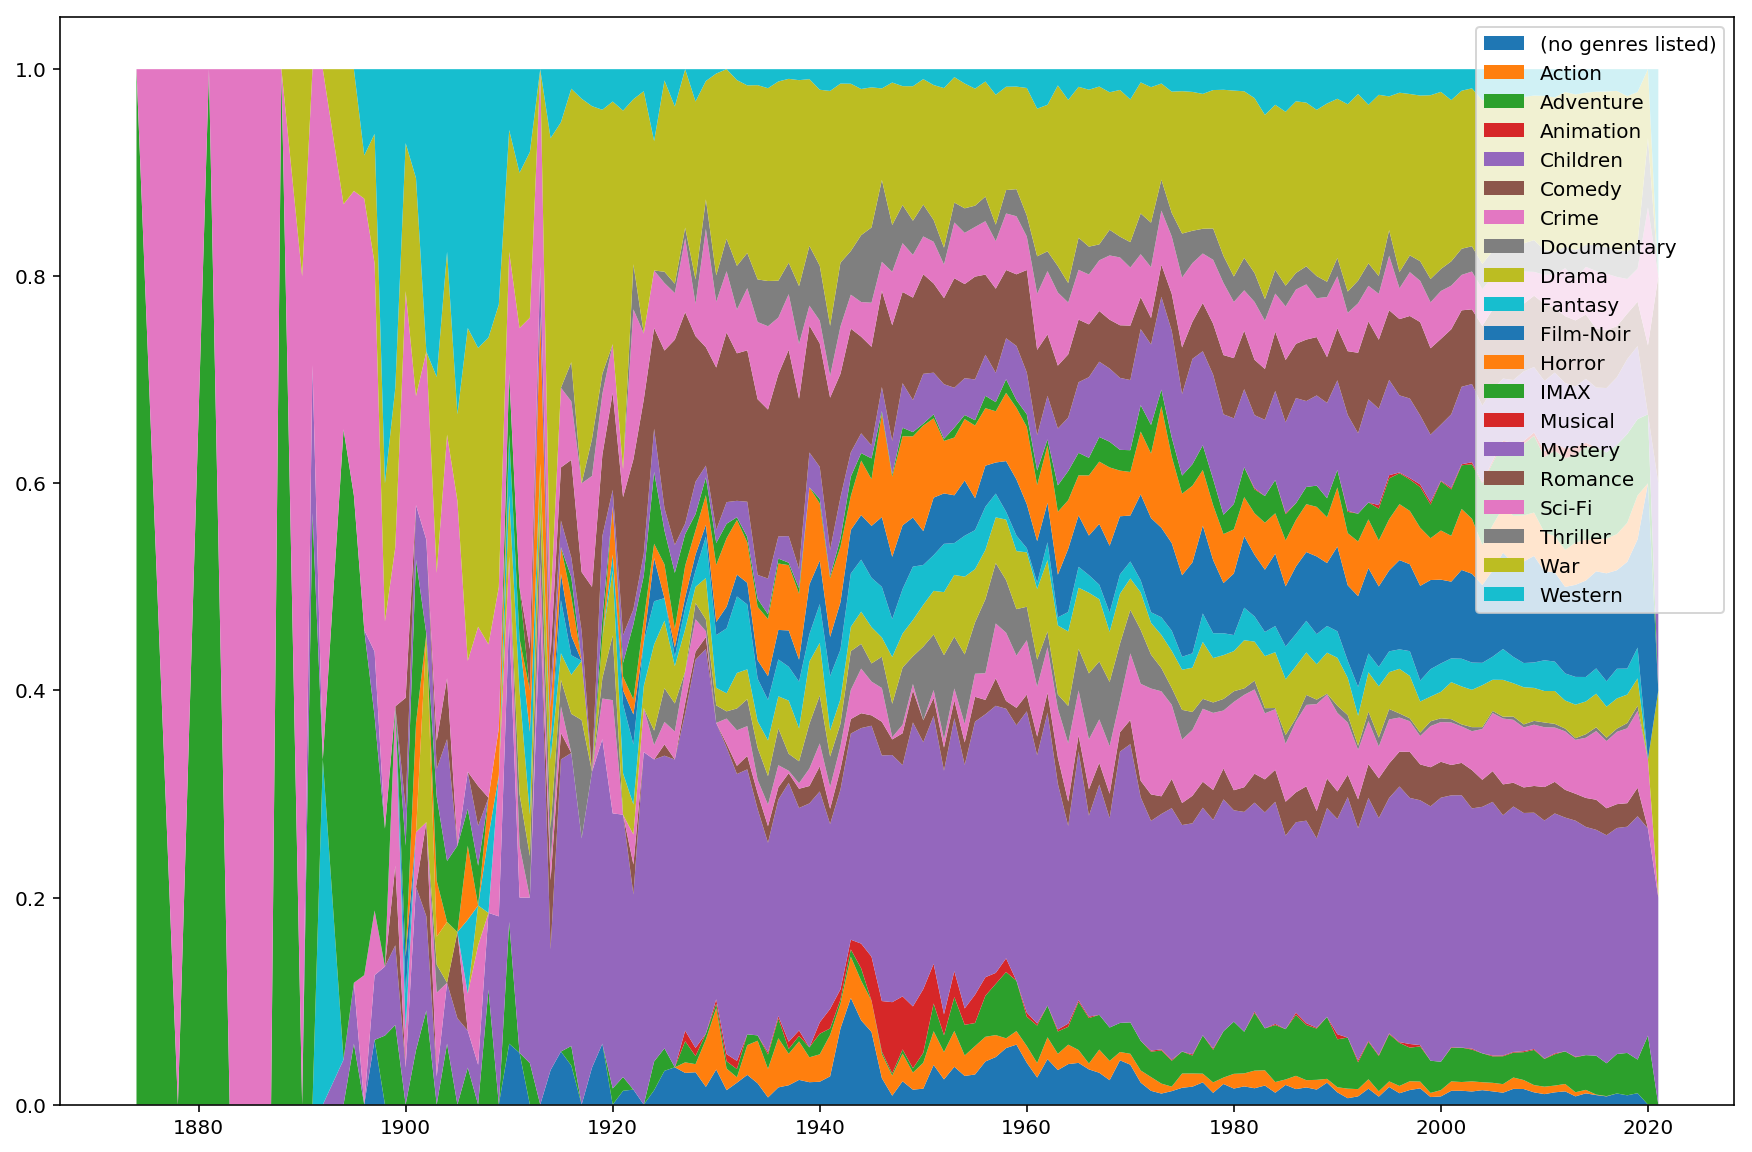

In [238]:
plt.figure(figsize=(15,10))
plt.stackplot(d.keys(),val, labels=genres_names)
plt.legend()
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [258]:
revenue_budget = tmdb \
    .map(lambda kv: (kv[0], 
                     (kv[1].get('revenue', None),
                     kv[1].get('budget', None)))) 

In [259]:
revenue_budget.take(5)

[(862, (373554033, 30000000)),
 (8844, (262797249, 65000000)),
 (15602, (0, 0)),
 (31357, (81452156, 16000000)),
 (11862, (76578911, 0))]

In [264]:
id_revenue_budget = links \
    .map(lambda x: (x[1][1],x[0])) \
    .join(revenue_budget) \
    .map(lambda x: (x[1])) 


In [265]:
id_revenue_budget.take(5)

[(139735, (0, 0)),
 (147308, (0, 0)),
 (174261, (0, 0)),
 (8921, (0, 0)),
 (923, (23217674, 839727))]

In [278]:
genres = sc.textFile(MOVIES_PATH)
genres = genres \
    .map(lambda x: x.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0])) \
    .map(lambda arr: (arr[0],arr[1][-1].split('|'))) \
    .flatMapValues(lambda arr: arr)

In [279]:
roi = genres \
.join(id_revenue_budget) \
.map(lambda x: x[1]) \
.reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])) \
.map(lambda x: (x[0], x[1][0]/np.max([x[1][1],1]))) \
.sortBy(lambda x: x[1], ascending=False)

In [280]:
rois = roi.collect()

In [281]:
rois

[('IMAX', 3.575514531264134),
 ('Animation', 3.53857846498367),
 ('Musical', 3.323755944655739),
 ('Adventure', 3.2072921198940243),
 ('Children', 3.090457625774435),
 ('Documentary', 3.087997822263929),
 ('Romance', 3.048998376959825),
 ('Fantasy', 3.010207886968221),
 ('Sci-Fi', 2.9920912076134987),
 ('Comedy', 2.8834000820754007),
 ('Horror', 2.8751552344153137),
 ('Action', 2.803847320893562),
 ('Mystery', 2.6455361339416426),
 ('Thriller', 2.565593492189654),
 ('Crime', 2.458730780169738),
 ('Drama', 2.4383206217360307),
 ('(no genres listed)', 2.2480406787118077),
 ('War', 2.0573761252451632),
 ('Film-Noir', 1.7103729583877307),
 ('Western', 1.5707315939106974)]

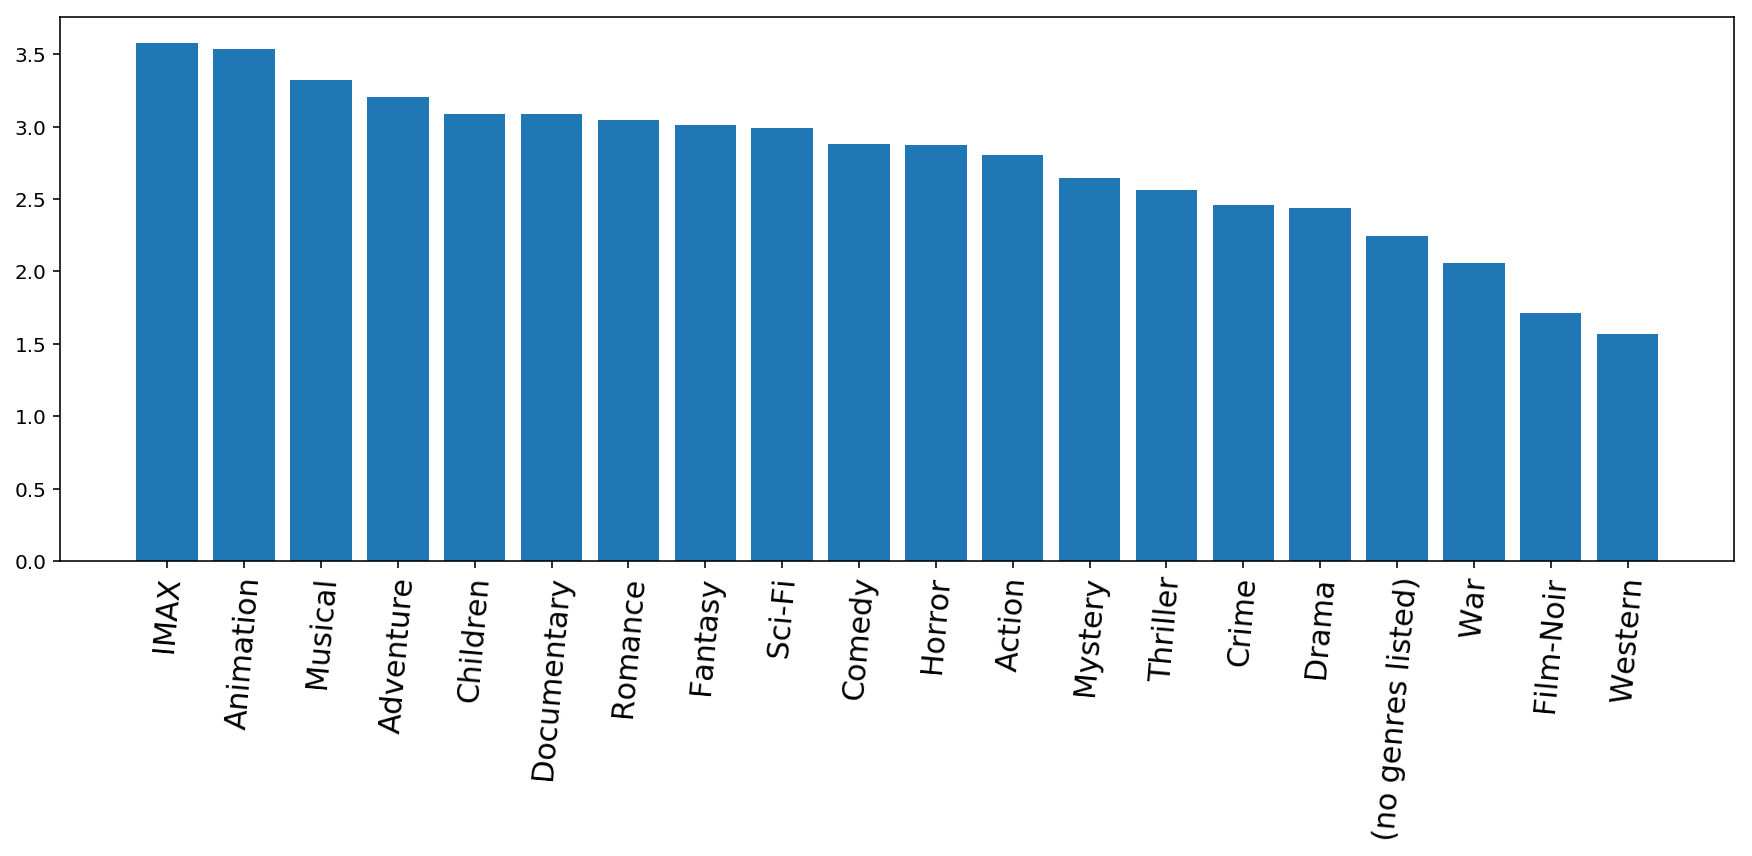

In [289]:
plt.figure(figsize=(15,5))
plt.bar(*zip(*rois))
plt.xticks(rotation=85, fontsize=15)
plt.show()